# Test biaslyze with disaster tweets data

Data source: https://www.kaggle.com/competitions/nlp-getting-started/overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [163]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and prepare data

In [4]:
df = pd.read_csv("../data/disaster-tweets/train.csv"); df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [151]:
df.shape

(7613, 5)

In [5]:
# replace urls
import re
url_regex = re.compile("(http|https)://[\w\-]+(\.[\w\-]+)+\S*")

df = df.replace(to_replace=url_regex, value='', regex=True)

## Train a model

In [34]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=10000, stop_words="english"), LogisticRegression(n_jobs=4))

In [35]:
clf.fit(df.text, df.target)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(n_jobs=4))])

In [36]:
train_pred = clf.predict(df.text)
print(accuracy_score(df.target, train_pred))

0.8418494680152371


## Test detection of concepts

In [37]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator

In [38]:
key_detect = KeywordConceptDetector()

In [39]:
detected_tweets = key_detect.detect(texts=df.text[:600])

2023-04-13 12:12:47.540 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 600 texts...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 62455.51it/s]
2023-04-13 12:12:47.554 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 412 texts with protected concepts.


In [40]:
len(detected_tweets)

412

In [41]:
detected_tweets

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 '#Flood in Bago Myanmar #We arrived Bago',
 "What's up man?",
 'this is ridiculous....',
 'Love my girlfriend',
 'The end!',
 'We always try to bring the he

## Test LIME based bias detection with keywords

In [127]:
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [128]:
bias_detector = LimeKeywordBiasDetector(bias_evaluator=LimeBiasEvaluator(n_lime_samples=100), n_top_keywords=30, use_tokenizer=True)

In [129]:
detection_res = bias_detector.detect(texts=df.text.sample(frac=0.1), predict_func=clf.predict_proba)

2023-04-13 15:01:59.900 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 761 texts...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 761/761 [00:07<00:00, 103.40it/s]
2023-04-13 15:02:07.264 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 125 texts with protected concepts.
2023-04-13 15:02:07.265 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 125 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.73it/s]


In [130]:
detection_res.summary()

Detected 118 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 66), ('nationality', 51), ('religion', 4)]
    Based on keywords: [('he', 15), ('california', 12), ('man', 12), ('her', 10), ('girl', 6), ('japan', 6), ('his', 6), ('she', 4), ('boy', 4), ('mom', 4), ('saudi', 4), ('turkish', 4), ('woman', 3), ('myanmar', 3), ('taiwan', 3), ('israel', 3), ('russian', 3), ('australia', 3), ('christian', 3), ('china', 3)].


In [131]:
detection_res.details(group_by_concept=True)

Concept: gender
[{'reason': ['he'],
  'text': "@Omar_molina036 @Milioooo_ he's trying to electrocute ya ass lol "
          "hell no I ain't fucking with Emilio no more ????????"},
 {'reason': ['she'],
  'text': "'[+54 -9] How do people not know who Kendall Jenner is? She has 6 "
          "times the Instagram followers of GD' SCREAMING LMAO"},
 {'reason': ['boy', 'girl'],
  'text': 'Shark boy and lava girl for the third time today. I guess this is '
          'what having kids feelings like. ??????'},
 {'reason': ['girl'],
  'text': '@IcyMagistrate \x89ÛÓher upper arm\x89ÛÒ those /friggin/ icicle '
          'projectiles\x89ÛÒ and leg from various other wounds the girl looks '
          'like a miniature more\x89ÛÓ'},
 {'reason': ['woman'],
  'text': 'Pandemonium In Aba As Woman Delivers Baby Without Face (Photos)  '},
 {'reason': ['boy', 'man'],
  'text': "The fact that the atomic bombs were called 'Little Boy' and 'Fat "
          "man' says a lot about the mentality that went into 

In [132]:
import yaml
from bokeh.layouts import column, row
from bokeh.models import (Button, ColorBar, ColumnDataSource, CustomJS,
                          DataTable, TableColumn, TextInput)
from bokeh.plotting import figure, show
from bokeh.io import show, output_notebook
from bokeh.themes import Theme
from bokeh.palettes import Spectral

output_notebook()

Loading BokehJS ...

In [133]:
res_df = pd.DataFrame({
    "text": [sample.text for sample in detection_res.biased_samples],
    "bias_concepts": [sample.bias_concepts for sample in detection_res.biased_samples],
    "keyword_position": [sample.keyword_position for sample in detection_res.biased_samples],
    "bias_keywords": [sample.bias_reasons for sample in detection_res.biased_samples],
    "num_tokens": [sample.num_tokens for sample in detection_res.biased_samples],
    "top_words": [sample.top_words for sample in detection_res.biased_samples],
    "score": [sample.score for sample in detection_res.biased_samples],
})
res_df["bias_concepts_joined"] = res_df.bias_concepts.apply(lambda x: ", ".join(x))
res_df["bias_keywords_joined"] = res_df.bias_keywords.apply(lambda x: ", ".join(x))

In [134]:
res_df.head()

,text,bias_concepts,keyword_position,bias_keywords,num_tokens,top_words,score,bias_concepts_joined,bias_keywords_joined
0,@Omar_molina036 @Milioooo_ he's trying to elec...,[gender],7,[he],19,"[electrocute, ass, trying, fucking, emilio, om...",-0.055180,gender,he
1,'[+54 -9] How do people not know who Kendall J...,[gender],19,[she],20,"[times, lmao, 54, people, has, know, followers...",0.000000,gender,she
2,The Latest: More homes razed by Northern Calif...,[nationality],1,[california],9,"[wildfire, california, homes, latest, the, raz...",0.192701,nationality,california
3,Shark boy and lava girl for the third time tod...,[gender],13,"[boy, girl]",18,"[having, today, lava, what, girl, third, the, ...",-0.007749,gender,"boy, girl"
4,@IcyMagistrate ÛÓher upper armÛÒ those /frig...,[gender],19,[girl],22,"[looks, other, a, arm, from, the, ûò, ûóher, l...",-0.017498,gender,girl


In [152]:
res_df["normalized_position"] = 1 - (res_df.keyword_position / res_df.num_tokens)

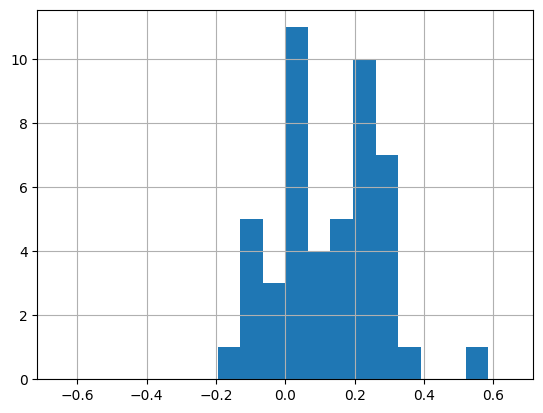

In [135]:
res_df[res_df.bias_concepts_joined == "nationality"].score.hist(bins=20, range=[-0.65, .65], align="mid");

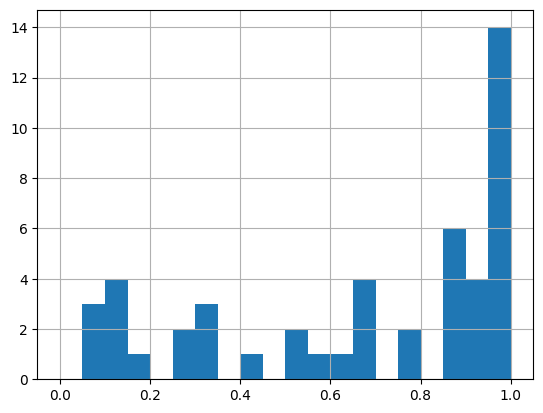

In [154]:
res_df[res_df.bias_concepts_joined == "nationality"].normalized_position.hist(bins=20, range=[0, 1], align="mid");

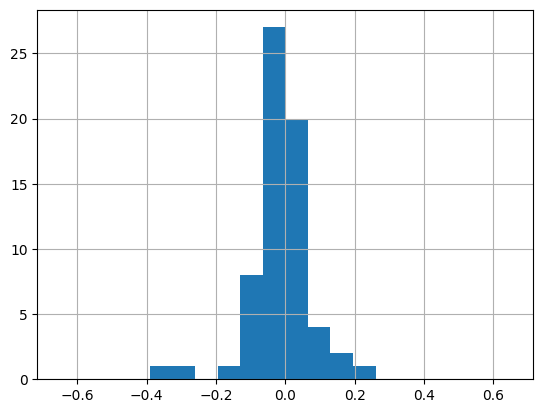

In [136]:
res_df[res_df.bias_concepts_joined == "gender"].score.hist(bins=20, range=[-0.65, .65], align="mid");

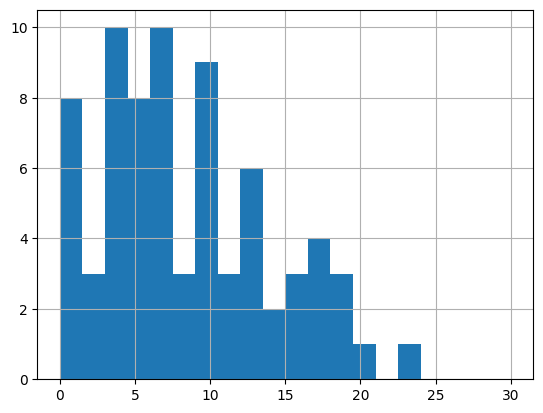

In [123]:
res_df[res_df.bias_concepts_joined == "gender"].keyword_position.hist(bins=20, range=[0.0, 30.0], align="mid");

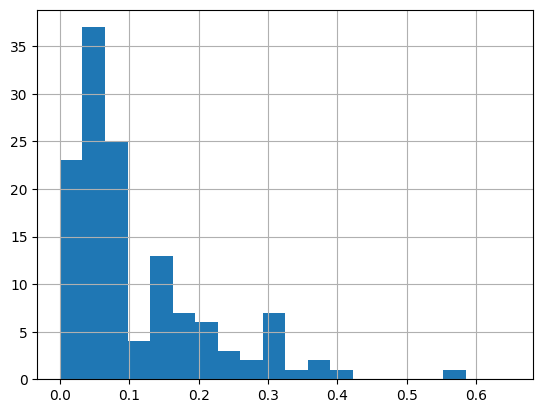

In [124]:
res_df.score.hist(bins=20, range=[0.0, .65], align="mid");

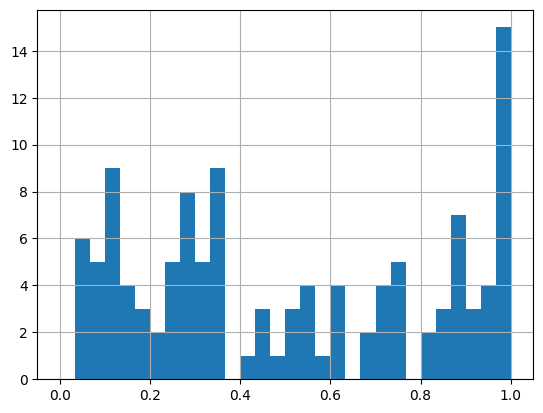

In [155]:
res_df.normalized_position.hist(bins=30, range=[0.0, 1.0], align="mid");

<Figure size 640x480 with 0 Axes>

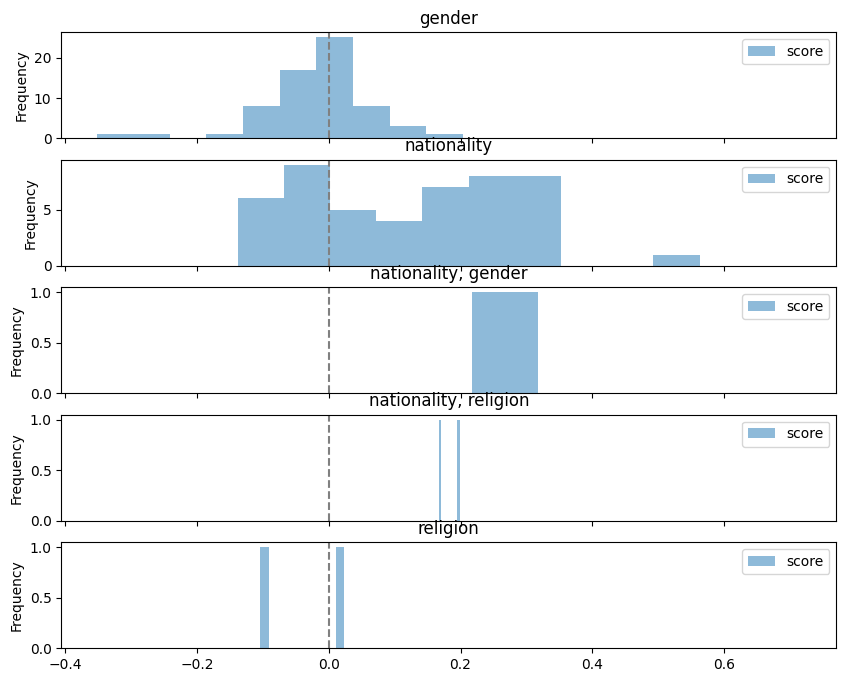

In [179]:
plt.figure();
axes = res_df[["score", "bias_concepts_joined"]].plot.hist(
    alpha=0.5,
    by="bias_concepts_joined",
    figsize=(10, 8),
    sharex=True
);
for ax in axes:
    ax.axvline(x=0, color='grey', linestyle='--');

In [148]:
def bkapp(doc):
    # update function for selection in histogram
    def update(attr, old, new):
        """Callback used for plot update when lasso selecting"""
        subset = res_df[res_df.keyword_position.isin(new)].sort_values(by=['keyword_position'])
        source.data = subset

    source = ColumnDataSource(data=dict())

    # define the text columns
    columns = [
        TableColumn(field="text", title="text", width=800),
        TableColumn(field="bias_concepts_joined", title="bias_concepts", width=100),
        TableColumn(field="keyword_position", title="keyword_position", width=50),
        TableColumn(field="bias_keywords_joined", title="bias_keywords", width=100),
        TableColumn(field="num_tokens", title="num_tokens", width=50),
        TableColumn(field="score", title="score", width=50)
    ]
    source = ColumnDataSource(res_df)
    source_orig = ColumnDataSource(data=res_df)

    data_table = DataTable(
        source=source, columns=columns, width=1100
    )
    source.data = res_df

    # define histogram part
   
    ## prepare the data
    plot_df = (res_df[["text", "keyword_position", "bias_concepts_joined"]]
     .groupby(["keyword_position", "bias_concepts_joined"])
     .count()
     .unstack()
     .fillna(0)
    )
    plot_df.columns = plot_df.columns.droplevel(0)
    plot_df = (
        pd.DataFrame({"keyword_position": np.arange(0, plot_df.index.max()+1, 1)})
        .join(plot_df, how="left")
        .fillna(0)
        .set_index("keyword_position")
    )
    biases = plot_df.columns.tolist()
    
    plot_dict = plot_df.to_dict("list")
    plot_dict["position"] = [str(x) for x in plot_df.index.tolist()]

    p = figure(x_range=plot_dict["position"], height=500, width=800, title="Bias keyword positions", tools="pan,wheel_zoom,xbox_select,reset", active_drag="xbox_select")

    stacked_bars = p.vbar_stack(biases, x='position', width=0.9, color = Spectral[11][:len(biases)], source=plot_dict, legend_label=biases)
    
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.location = "top_right"
    p.legend.orientation = "horizontal"
        
    # selection handler
    for bar in stacked_bars:
        bar.data_source.selected.on_change("indices", update)
    
    # put everything together
    doc.add_root(column(p, data_table))
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

In [150]:
show(bkapp)

## Testing a sentiment analysis model from huggingface

In [25]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [26]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [27]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [28]:
test_texts = detected_tweets[:10]
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

2023-04-13 10:09:41.105 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 10 texts...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 109.41it/s]
2023-04-13 10:09:41.200 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 2 texts with protected concepts.
2023-04-13 10:09:41.201 | INFO     | biaslyze.evaluators:evaluate:42 - Started bias detection on 2 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:38<00:00, 19.30s/it]


In [29]:
detection_res.summary()

Detected 1 samples with potential issues.
    Potentially problematic concepts detected: [('nationality', 1)]
    Based on keywords: [('california', 1)].


In [30]:
detection_res.details(group_by_concept=True)

Concept: nationality
[{'reason': ['california'],
  'text': '13,000 people receive #wildfires evacuation orders in California '}]


## !! Very Experimental !!: Test masked language model based bias detection with keywords

In [31]:
from biaslyze.bias_detectors import MaskedKeywordBiasDetector

In [32]:
bias_detector = MaskedKeywordBiasDetector(n_resample_keywords=15, use_tokenizer=True)

In [33]:
detection_res = bias_detector.detect(texts=df.text[500:600], predict_func=predict_sentiment)

2023-04-13 10:10:20.112 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 100 texts...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 97.01it/s]
2023-04-13 10:10:21.147 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 17 texts with protected concepts.
2023-04-13 10:10:21.147 | INFO     | biaslyze.evaluators:evaluate:105 - Started bias detection on 17 samples...
 12%|█████████████████████▍                                                                                                                                                                | 2/17 [00:03<00:22,  1.50s/it]


TypeError: BiasedSampleResult.__init__() missing 3 required positional arguments: 'top_words', 'num_tokens', and 'keyword_position'

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details()